# Quadrotor Trajectory Tracking with Flowpipe Visualization

This notebook demonstrates:
1. Planning a polynomial trajectory through waypoints
2. Computing invariant sets for tracking under disturbances
3. Visualizing flowpipes (reachable sets along the trajectory)

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Add repo root to path
repo_root = None
for path in [Path.cwd().resolve()] + list(Path.cwd().resolve().parents):
    if (path / "cp_reach").exists():
        repo_root = path
        break
if repo_root is None:
    raise RuntimeError("Could not locate repo root")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from cp_reach.development.applications.quadrotor.trajectory import find_cost_function, plan_trajectory
from cp_reach.development.applications.quadrotor.invariant import solve_nested
from cp_reach.plotting.plotting import flowpipes, plot_flowpipes, plot_error_bounds_2d

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

In [ ]:
%load_ext autoreload
%autoreload 2

## 1. Plan Polynomial Trajectory

Define waypoints and generate a smooth minimum-snap trajectory.

In [ ]:
# Trajectory parameters
num_coords = 7
n_legs = num_coords - 1  # Number of segments
poly_deg = 7              # Polynomial degree
min_deriv = 4             # Minimize snap (4th derivative)
bc_deriv = 4              # Boundary conditions up to jerk

# Waypoints (position)
pos = [
    [0, 0, 0],
    [7.04, -0.76, 0],
    [10.04, 1.7, 0],
    [10.22, 6.6, 0],
    [13.33, 8.65, 0],
    [20.15, 8.14, 0],
    [19.6, -1.92, 0]
]

# Velocity at waypoints
vel = [
    [0, 0, 0],
    [2.37, 0, 0],
    [0.15, 2.67, 0],
    [0.49, 2.28, 0],
    [2.85, -0.23, 0],
    [0, 0, 0],
    [0, 0, 0]
]

# Acceleration and jerk (zero at all waypoints)
acc = [[0, 0, 0] for _ in range(num_coords)]
jerk = [[0, 0, 0] for _ in range(num_coords)]

# Stack boundary conditions
bc = np.stack((pos, vel, acc, jerk))

# Time weight for optimization
k_time = 1e5

# Segment durations (seconds)
T_legs = [4.67, 2.17, 1.84, 1.92, 5.5, 6.46]

print("Computing cost function for trajectory optimization...")
cost = find_cost_function(
    poly_deg=poly_deg,
    min_deriv=min_deriv,
    rows_free=[],
    n_legs=n_legs,
    bc_deriv=bc_deriv,
)

print("Planning trajectory...")
ref = plan_trajectory(bc, cost, n_legs, poly_deg, k_time, T_legs)

print(f"Trajectory planned with {len(ref['x'])} points")

Computing cost function for trajectory optimization...
Planning trajectory...
Trajectory planned with 600 points


### Visualize Trajectory in 3D

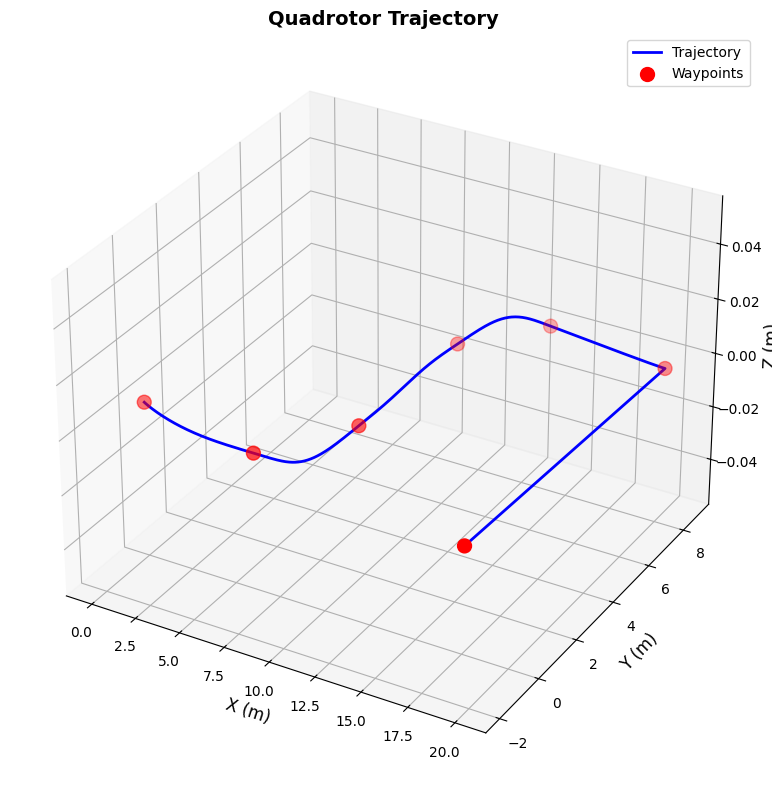

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot trajectory
ax.plot(ref["x"], ref["y"], ref["z"], "b-", linewidth=2, label="Trajectory")

# Plot waypoints
ax.scatter(*zip(*pos), c="r", s=100, marker='o', label="Waypoints")

ax.set_xlabel("X (m)", fontsize=12)
ax.set_ylabel("Y (m)", fontsize=12)
ax.set_zlabel("Z (m)", fontsize=12)
ax.set_title("Quadrotor Trajectory", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Compute Invariant Set

Solve for the invariant set that bounds tracking errors under disturbances.

In [ ]:
# Disturbance bounds
vel_dist = 0.0           # m/s velocity disturbance
accel_dist = 0.0         # m/s^2 acceleration disturbance
ang_accel_dist = 1.0     # rad/s^2 angular acceleration disturbance

print("Solving for invariant set...")
print(f"  Velocity disturbance: {vel_dist} m/s")
print(f"  Acceleration disturbance: {accel_dist} m/s^2")
print(f"  Angular acceleration disturbance: {ang_accel_dist} rad/s^2")

result = solve_nested(
    vel_dist=vel_dist,
    accel_dist=accel_dist,
    ang_accel_dist=ang_accel_dist,
    ref=ref
)

# Extract results - updated to match the new return structure
angular_result = result['angular']
se3_result = result['se23']

ang_vel_points = angular_result['points']
angular_bounds = angular_result['bounds']
omega_dist = angular_result['omega_dist']
dynamics_sol = angular_result['lmi_solution']

xi_points = se3_result['points_algebra']     # Lie algebra coordinates (9, N)
eta_points = se3_result['points_group']      # Lie group coordinates (9, N)
xi_bounds = se3_result['bounds_algebra']     # Lie algebra bounds (9, 2)
eta_bounds = se3_result['bounds_group']      # Lie group bounds (9, 2)
kinematics_sol = se3_result['lmi_solution']

print("\nInvariant set computed!")
print(f"  Position bounds (Lie algebra): [{xi_bounds[:3, 0]}] to [{xi_bounds[:3, 1]}]")
print(f"  Position bounds (Lie group):   [{eta_bounds[:3, 0]}] to [{eta_bounds[:3, 1]}]")

Solving for invariant set...
  Velocity disturbance: 0.0 m/s
  Acceleration disturbance: 0.0 m/s^2
  Angular acceleration disturbance: 1.0 rad/s^2

Invariant set computed!
  Position bounds (Lie algebra): [[-0.88526483 -0.92255105 -0.91176348]] to [[0.88526483 0.92255105 0.91176348]]
  Position bounds (Lie group):   [[-0.88526483 -0.92255105 -0.91176348]] to [[0.88526483 0.92255105 0.91176348]]


## 3. Visualize Invariant Set

Plot the invariant set in both Lie algebra and Lie group coordinates.

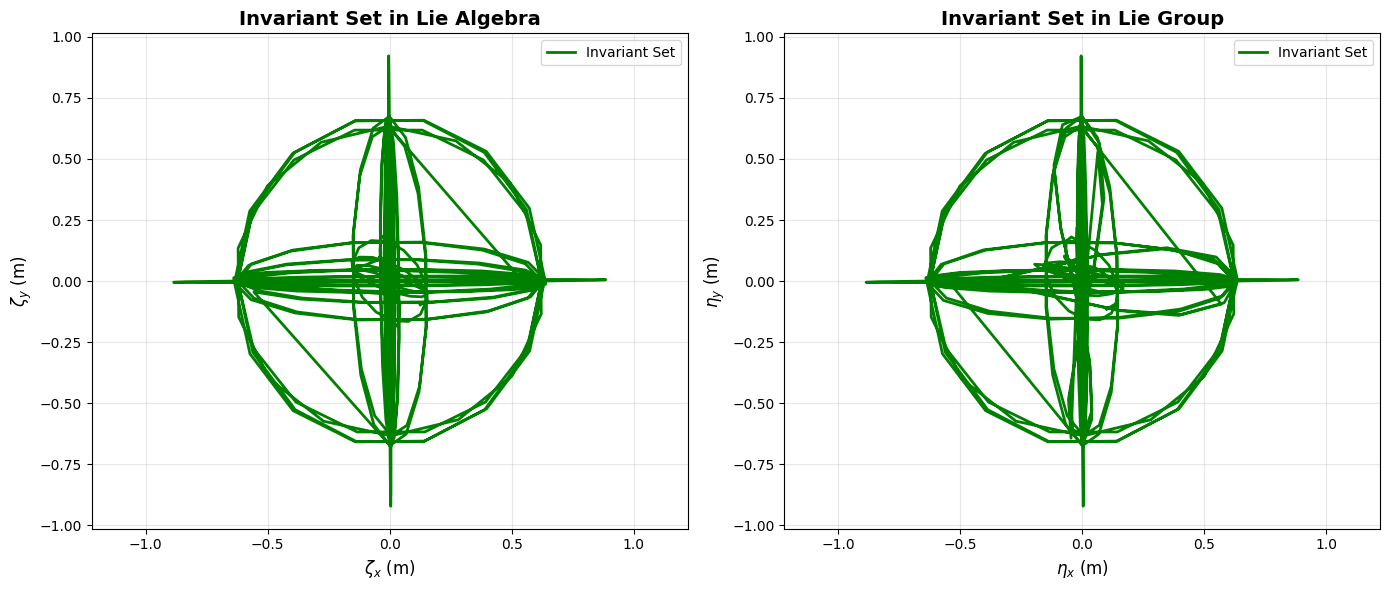

In [ ]:

fig = plot_error_bounds_2d(xi_points, eta_points)

## 4. Compute and Visualize Flowpipes

Generate flowpipes (reachable sets) along the trajectory.

In [ ]:
print("Computing flowpipes...")

# Compute flowpipes along trajectory
flowpipes_list, nominal_traj = flowpipes(
    ref=ref,
    step=2,                    # Number of segments
    vel_dist=vel_dist,          # Velocity disturbance
    accel_dist=accel_dist,      # Linear disturbance
    omega_dist=omega_dist,      # Angular disturbance
    sol=kinematics_sol,         # LMI solution
    axis='xy'                   # Projection axis
)

print(f"Generated {len(flowpipes_list)} flowpipe segments")

Computing flowpipes...
Generated 300 flowpipe segments


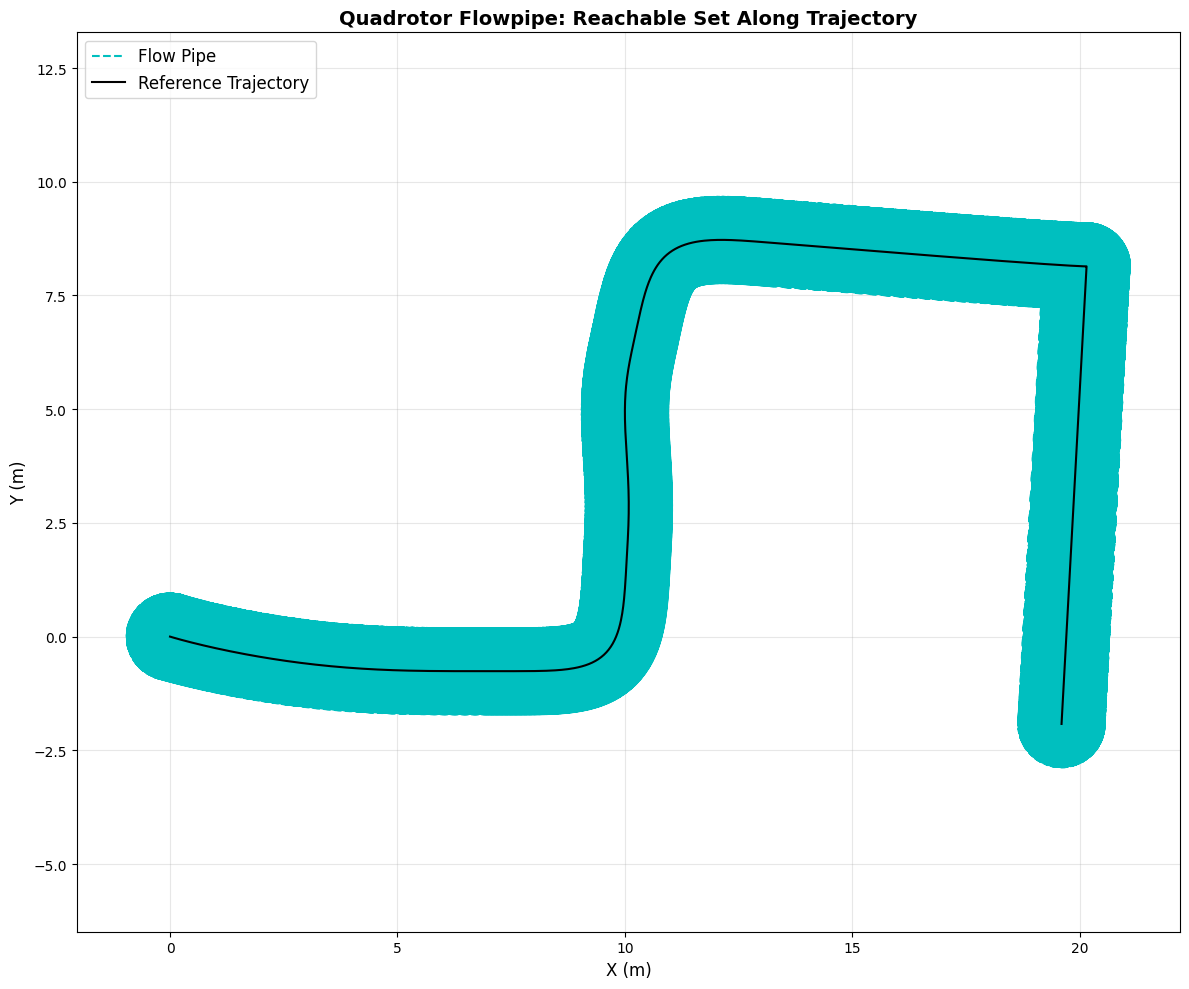

In [ ]:
# Plot flowpipes
fig, ax = plt.subplots(figsize=(12, 10))

plot_flowpipes(nominal_traj, flowpipes_list, ax=ax, axis='xy')

ax.set_xlabel('X (m)', fontsize=12)
ax.set_ylabel('Y (m)', fontsize=12)
ax.set_title('Quadrotor Flowpipe: Reachable Set Along Trajectory', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.show()

## 5. Summary

This notebook demonstrated:
- **Trajectory Planning**: Minimum-snap polynomial trajectory through waypoints
- **Invariant Set Computation**: LMI-based bounds for tracking errors
- **Flowpipe Visualization**: Time-varying reachable sets showing guaranteed tracking performance

The flowpipe shows the region where the quadrotor is guaranteed to remain despite disturbances, as long as tracking errors start within the invariant set.